# Работа с временными рядами

**Временной ряд** - последовательно измеренные через некоторые (зачастую равные) промежутки времени данные.

Обычно в задачах анализа данных предполагается независимость наблюдений. При работе с временными рядами мы строим свой прогноз на основе наблюдений из прошлого.

Компоненты временного ряда:
- Тренд - систематическая линейная или нелинейная компонента, изменяющаяся во времени.
- Сезонность - периодические колебания уровней временного ряда внутри года (например).
- Цикл - периодические колебания, как правило, больше, чем один сезоннный период, не имеют определенной продолжительности.
- Ошибка - непрогнозируемая компонента.
- Уровень - среднее значение временного ряда.

<img width = '800px' src="images/img-2022-02-14-14-55-39.png">

In [1]:
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams
import warnings
from pandas.core.nanops import nanmean as pd_nanmean

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings('ignore')
%matplotlib inline

Датасет ежечасного потребления электроэнергии за последние 10 лет американской компании AEP в мегаваттах.

https://www.kaggle.com/robikscube/hourly-energy-consumption#AEP_hourly.csv

In [2]:
energy_consumption = pd.read_csv('files/lesson_10/AEP_hourly.csv', sep =',',
                                 parse_dates=['Datetime'], index_col='Datetime')
energy_consumption.sort_index(inplace=True)
energy_consumption = energy_consumption.iloc[-30000:]

energy_consumption.head(2)

,AEP_MW
Datetime,
2015-03-02 00:00:00,15867.0
2015-03-02 01:00:00,15444.0


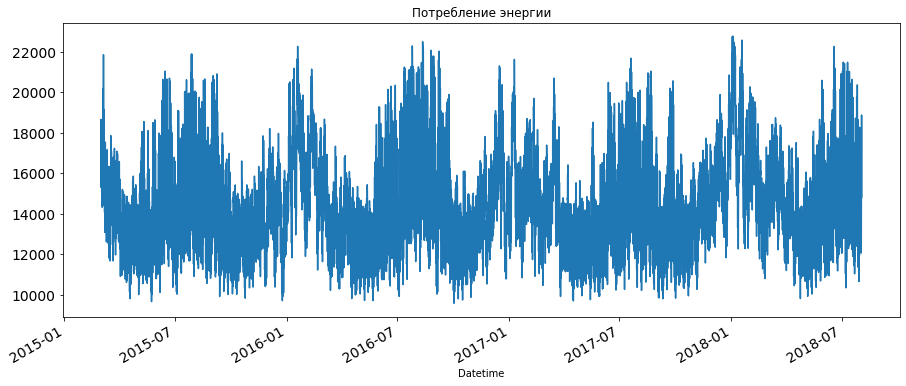

In [3]:
energy_consumption.AEP_MW.plot( figsize=(15,6),title= 'Потребление энергии', fontsize=14)
plt.show()

### **Компоненты временного ряда**

Наш временной ряд раскладывается на отдельные компоненты, работая по отдельности с каждой из них будет проще строить прогноз. Отдельные компоненты временного ряда очень похожи на краски, которые смешиваются и получается определенный цвет (наш исходный временной ряд).

<img width = '500px' src="images/paintings.jpg">

$Y_t = f(Trend, Seasonality, Reminder) $

$\\ Y_t = Trend + Seasonality + Reminder  - additive $
$\\ Y_t = Trend * Seasonality * Reminder  - multiplicative$

#### 1. Сезонность

In [6]:
rcParams['figure.figsize'] = 20, 5
energy_consumption['year'] = energy_consumption.index.year
energy_consumption['month'] = energy_consumption.index.month
energy_consumption['hour'] = energy_consumption.index.hour
energy_consumption['dow'] = energy_consumption.index.dayofweek
energy_consumption_pivot = pd.pivot_table(energy_consumption, values = "AEP_MW", columns = "year", index = "month")
energy_consumption.head(2)

,AEP_MW,year,month,hour,dow
Datetime,,,,,
2015-03-02 00:00:00,15867.0,2015,3,0,0
2015-03-02 01:00:00,15444.0,2015,3,1,0


In [7]:
energy_consumption_pivot.head(2)

year,2015,2016,2017,2018
month,,,,
1,NaN,16760.747312,15566.197581,17594.87500
2,NaN,15895.386494,14665.684524,15276.66369


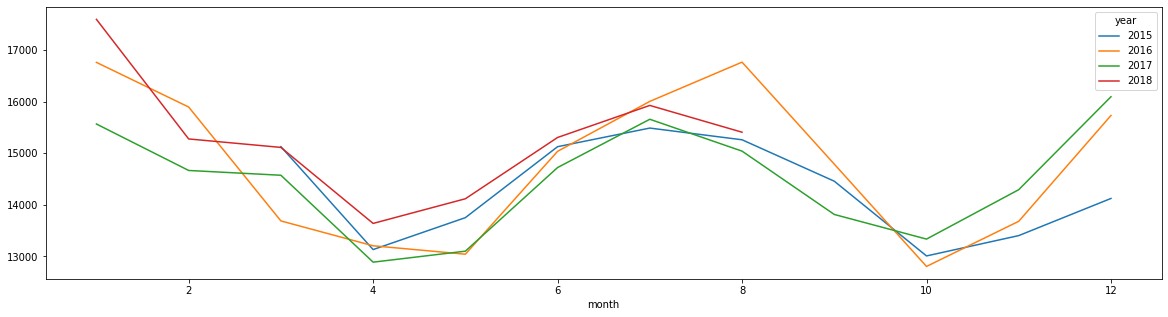

In [9]:
energy_consumption_pivot.plot()
plt.show()

##### 2. Тренд

Тренд можно извлечь с помощью скользящей средней по исходному временному ряду. 

$ MA =  \frac{1} {2m} \sum_{i=-1}^m (Y_{t+i}) $

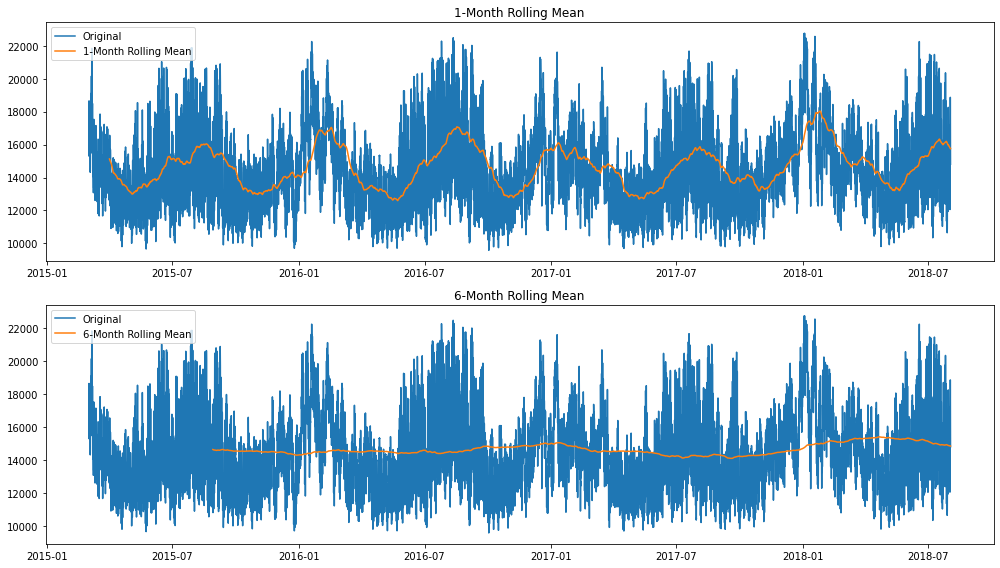

In [10]:
fig, axes = plt.subplots(2, 1, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

window = 24*30
axes[0].plot(energy_consumption.index, energy_consumption.AEP_MW, label='Original')
axes[0].plot(energy_consumption.index, energy_consumption.AEP_MW.rolling(window=window).mean(), label='1-Month Rolling Mean')
axes[0].set_title("1-Month Rolling Mean")
axes[0].legend(loc='best')

window = 24*30*6
axes[1].plot(energy_consumption.index, energy_consumption.AEP_MW, label='Original')
axes[1].plot(energy_consumption.index, energy_consumption.AEP_MW.rolling(window=window).mean(), label='6-Month Rolling Mean')
axes[1].set_title("6-Month Rolling Mean")
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

Чтобы извлечь тренд нужно использовать окно равное сезонности временного ряда (сезонность можно понять как визуально по графику, так и с помощью рядов Фурье - https://anomaly.io/detect-seasonality-using-fourier-transform-r/index.html).

##### 3. Остатки

То, что осталось после удаления сезонности и тренда, остаки должны напоминать белый шум.

**Декомпозиция временного ряда**

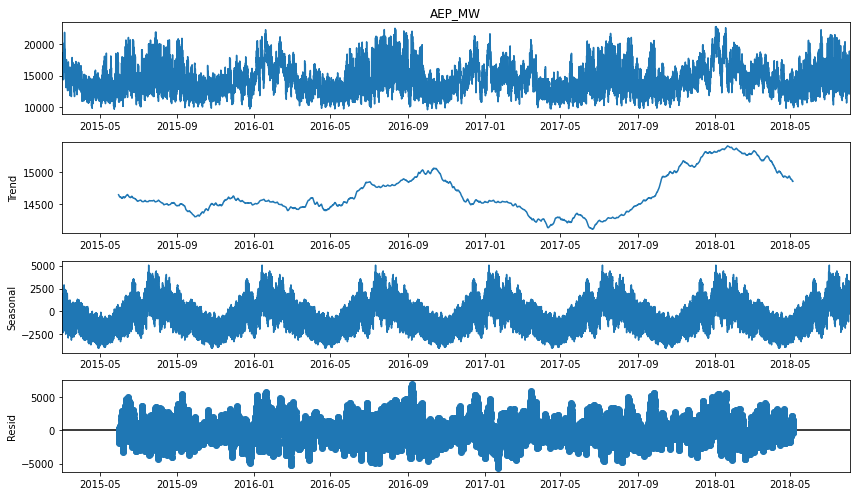

In [11]:
# STL-декомпозиция ряда
rcParams['figure.figsize'] = 12, 7
result = sm.tsa.seasonal_decompose(energy_consumption.AEP_MW, model='additive',freq= 24*30*6)
result.plot()
plt.show()

Модели, с помощью которых можно описать временной ряд.

<img width = '700px' src="images/lesson_10/methods.png">

Исходный временной ряд.

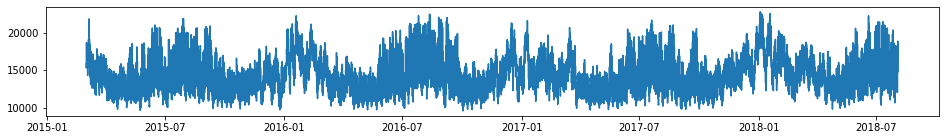

In [25]:
plt.figure(figsize=(16,2))

plt.plot(energy_consumption.AEP_MW)
plt.show()

Плавающее среднее.

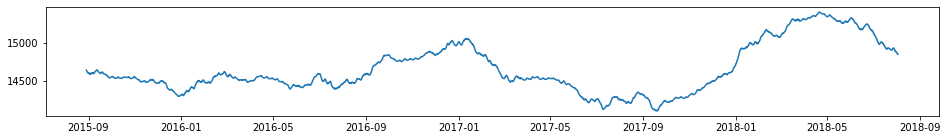

In [27]:
plt.figure(figsize=(16,2))

MA = energy_consumption.AEP_MW.rolling(window=24*30*6).mean()

plt.plot(MA)
plt.show()

Убираем тренд.

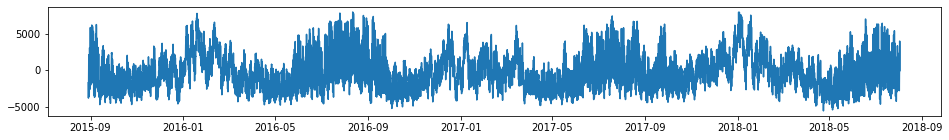

In [28]:
detrend_ = energy_consumption.AEP_MW - MA
# detrend_ = energy_consumption.AEP_MW / MA

plt.figure(figsize=(16,2))

plt.plot(detrend_)
plt.show()

Нормализуем по дням сезона

In [29]:
def seasonal_mean(x, period):
    """
    Return means for each period in x. period is an int that gives the
    number of periods per cycle. E.g., 12 for monthly. NaNs are ignored
    in the mean.
    """
    return np.array([pd_nanmean(x[i::period], axis=0) for i in range(period)])

In [31]:
s_a = seasonal_mean(detrend_, 24*30*6)
s_a -= np.mean(s_a, axis=0)

nobs = detrend_.shape[0]
seasonal = np.tile(s_a.T, nobs // 24*30*6 + 1).T[:nobs]

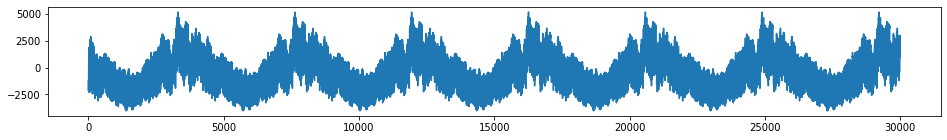

In [32]:
plt.figure(figsize=(16,2))

plt.plot(seasonal)
plt.show()

Остатки

In [33]:
residuals = energy_consumption.AEP_MW - MA - seasonal

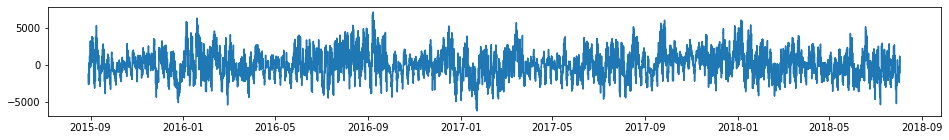

In [34]:
plt.figure(figsize=(16,2))

plt.plot(residuals)
plt.show()

### Предсказание по временному ряду

In [4]:
w_hours = 24
train = energy_consumption.iloc[:-w_hours]
val   = energy_consumption.iloc[-w_hours:]

**Задача** - предсказать потребление энергии на следующий день.

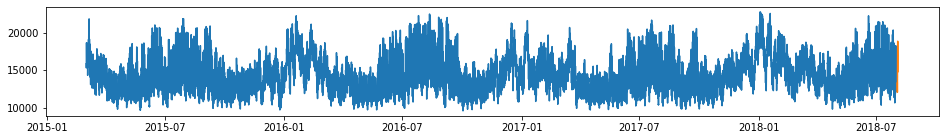

In [5]:
plt.figure(figsize=(16,2))

plt.plot(train.AEP_MW)
plt.plot(val.AEP_MW)

plt.show()

In [410]:
def plot_forecast(preds):
    
    forecast = pd.Series(preds)
    forecast.index = val.index
    
    plt.figure(figsize=(20,6))
    plt.plot(train.AEP_MW[-120:], label = 'train', linewidth = 3)
    plt.plot(val.AEP_MW, label = 'validation', color = 'cyan', linewidth = 3)
    plt.plot(forecast, '--', label = 'forecast', color = 'orange', linewidth = 2)
    plt.legend()
    plt.show()

#### 1. Baseline

In [411]:
preds = [train.AEP_MW.mean()] * w_hours

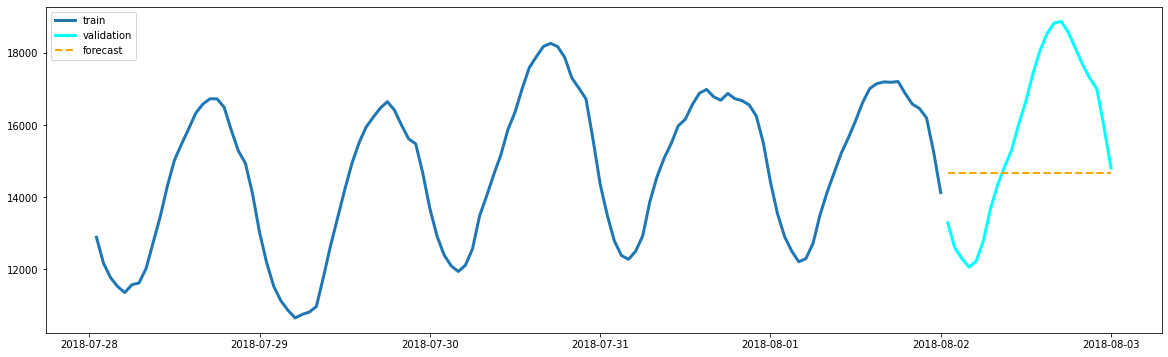

In [412]:
plot_forecast(preds)

В качестве бейзлайнового решения будет прогноз средним за последние 24 час.

In [413]:
#Будем вычислять RMSE для определеиния качества прогноза
from sklearn.metrics import mean_squared_error
from math import sqrt
    
def rmse(y_actual, y_predicted):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    return rmse

In [414]:
print('RMSE - ', rmse(val.AEP_MW, preds))

RMSE -  2542.1243340173924


In [415]:
# Относительная ошибка - хорошая метрика для бизнеса
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [416]:
print('MAPE - ', mean_absolute_percentage_error(val.AEP_MW,  preds))

MAPE -  13.881442128007624


##### 2.  Наивный подход

"Завтра = вчера"

${Y}_{t} =  Y_{t-n}$

In [417]:
preds = train.iloc[-w_hours:].AEP_MW.values

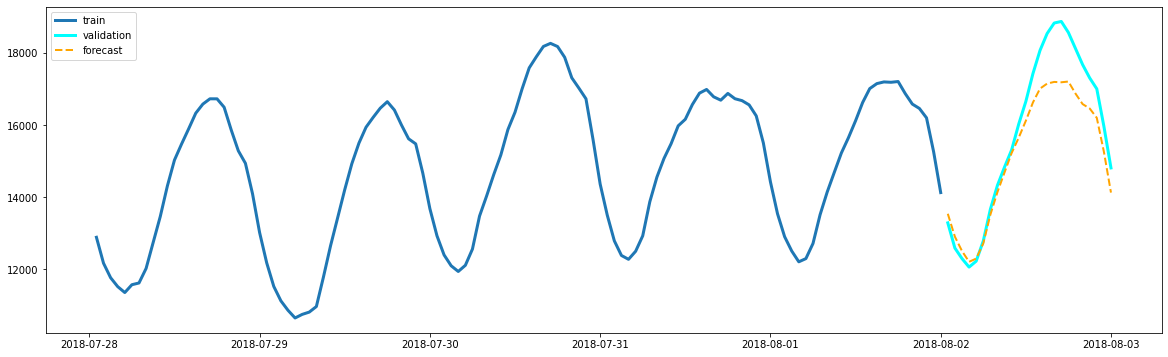

In [418]:
plot_forecast(preds)

In [419]:
print('RMSE - ', rmse(val.AEP_MW, preds))
print('MAPE - ', mean_absolute_percentage_error(val.AEP_MW,  preds))

RMSE -  838.5639262055895
MAPE -  3.8569350818642745


##### 3. Предсказание плавающем средним

Новое значение будет вычисляться на основе среднего за конкретный период.

${Y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} Y_{t-n}$

In [420]:
#Оцениваем по последним N неделям
n = 10
tr_sample = train.iloc[-n*w_hours:]
preds_arr = np.array(tr_sample.AEP_MW).reshape(n,-1)

preds = preds_arr.mean(axis = 0)

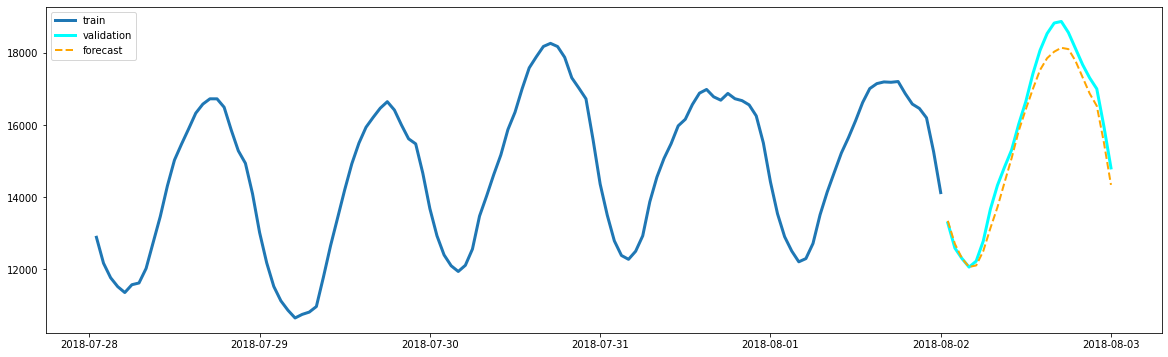

In [421]:
plot_forecast(preds)

In [422]:
print('RMSE - ', rmse(val.AEP_MW, preds))
print('MAPE - ', mean_absolute_percentage_error(val.AEP_MW,  preds))

RMSE -  430.80165099497935
MAPE -  2.261731940436


##### 4. Взвешенное среднее

${Y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n Y_{t-n}$

In [423]:
W = np.array([0.001, 0.004, 0.005, 0.01 , 0.02 , 0.05 , 0.1  , 0.15 , 0.26 , 0.4])
preds_arr_W = np.array([preds_arr[x]*W[x] for x in range(len(W))])
preds = preds_arr_W.sum(axis = 0)

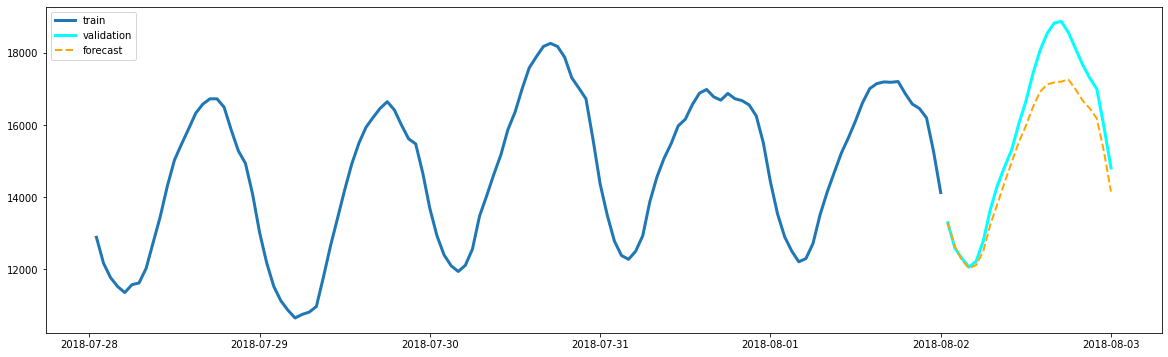

In [424]:
plot_forecast(preds)

In [425]:
print('RMSE - ', rmse(val.AEP_MW, preds))
print('MAPE - ', mean_absolute_percentage_error(val.AEP_MW,  preds))

RMSE -  853.2407205091653
MAPE -  4.057324648476928


Качество ухудшилось, но можно подобрать веса лучше.

##### 5. Простое экспоненциальное сглаживание - simple exponential smoothing (SES)


Этот метод подходит для прогнозирования данных без четкой тенденции или сезонной компоненты.

Для прогноза будем учитывать все наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные.

${f}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot f_{t-1} $

где $y_t$ - фактическое значение ряда на период времени $t$, ${f}_{t}$  - предсказанное значение ряда

In [152]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result[-1]

In [153]:
#Простой пример
series_val = [1,2,3,4,5,6]
result = [series_val[0]]

#alpha - насколько сильно мы не хотим помнить, что было в прошлом
alpha = 0.9
# alpha = 0.1

for n in range(1, len(series_val)):
    result.append(alpha * series_val[n] + (1 - alpha) * result[n-1])
    
result[-1]   

5.88889

<img width = '500px' src="images/lesson_10/ses.png">

Попробуем интуитивно понять, что за этим стоит, раскроем скобки:

${f}_{t} = \alpha \cdot y_t + f_{t-1}- \alpha \cdot f_{t-1} $

${f}_{t} = f_{t-1} + \alpha \cdot ( y_t - f_{t-1}) $ -> ${f}_{t} = f_{t-1} + \alpha e_t $

То есть мы строим свой прогноз как бы учитывая ошибку, которую мы сделали на предыдущем шаге.

Две крайности:
- $ \alpha = 0$: прогноз - просто среднее

- $ \alpha = 1$: наивное предсказание

Построим прогноз:

In [426]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
fit = SimpleExpSmoothing(np.asarray(energy_consumption.AEP_MW)).fit(smoothing_level=0.7,optimized=False)
preds = fit.forecast(24)

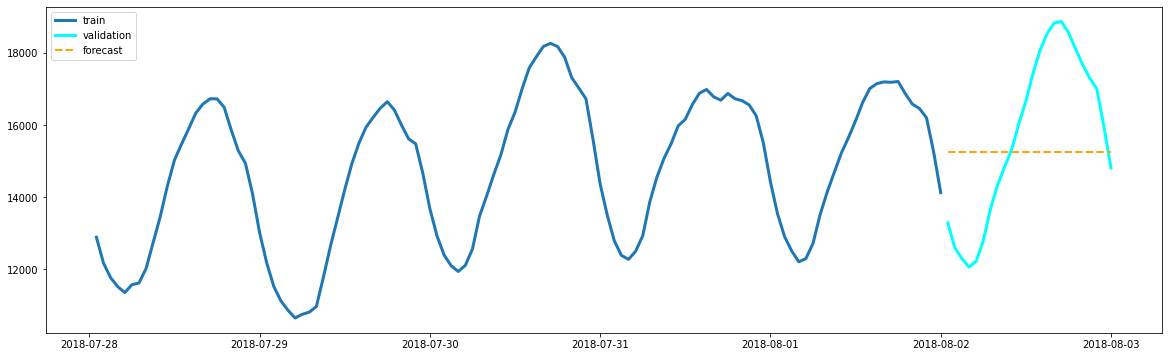

In [427]:
plot_forecast(preds)

Для понимания более сложных методов прогнозирования временных рядов будем использовать представление в компонентном виде:

- компонента прогноза: ${f}_{t} = l_t $
- компонента сглаживания: ${l}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot l_{t-1} $

##### 6. Двойное экспоненциальное сглаживание - модель Хольта

Подходит для работы с временными рядами, где есть устойчивый линейный тренд.

Есть следующие компоненты:
- компонента прогноза: ${f}_{t} = l_t + b_t$
- компонента уровня: ${l}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot (l_{t-1} + b_{t-1})$
- компонента тренда: ${b}_{t} = \beta \cdot (l_{t} - l_{t-1}) + (1-\beta) \cdot b_{t-1}$

Итоговое предсказание представляет собой сумму модельных значений уровня и тренда.

In [428]:
def double_exponential_smoothing(series, alpha, beta, horizon = 1):
    h = horizon - 1
    result = [series[0]]
    for n in range(1, len(series) + h):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result[-horizon:]

In [429]:
preds = double_exponential_smoothing(energy_consumption.AEP_MW, 0.4, 0.2, horizon = 24)
np.array(preds)

array([15661.97326338, 15304.94451478, 14947.91576618, 14590.88701757,
       14233.85826897, 13876.82952037, 13519.80077177, 13162.77202317,
       12805.74327457, 12448.71452597, 12091.68577736, 11734.65702876,
       11377.62828016, 11020.59953156, 10663.57078296, 10306.54203436,
        9949.51328575,  9592.48453715,  9235.45578855,  8878.42703995,
        8521.39829135,  8164.36954275,  7807.34079415,  7450.31204554])

In [491]:
fit = Holt(np.array(energy_consumption.AEP_MW)).fit(smoothing_level = 0.7, 
                                                    smoothing_slope = 0.05)
preds = fit.forecast(24)

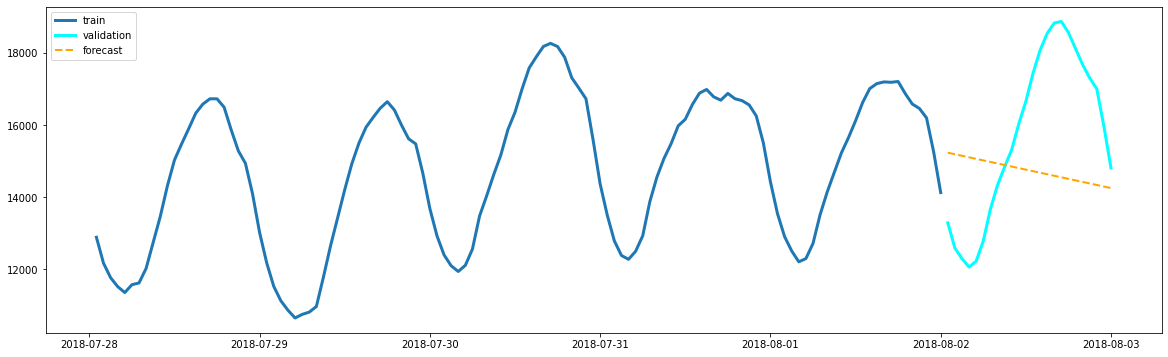

In [492]:
plot_forecast(preds)

##### 7. Тройное экспоненциальное сглаживание - модель Хольта - Винтерса

Учитывает в том числе и сезонность.

Есть следующие компоненты (additive variation):
- компонента прогноза: ${f}_{t} = l_t + b_t + s_{t-m}$
- компонента уровня: ${l}_{t} = \alpha \cdot (y_t - s_{t-m}) + (1-\alpha) \cdot (l_{t-1} + b_{t-1})$
- компонента тренда: ${b}_{t} = \beta \cdot (l_{t} - l_{t-1}) + (1-\beta) \cdot b_{t-1}$
- компонента сезонности: ${s}_{t} = \gamma \cdot (y_{t}-l_{t-1}-b_{t-1}) + (1-\gamma) \cdot s_{t-m}$


$m $ - период сезональности

In [522]:
fit = ExponentialSmoothing(np.array(energy_consumption.AEP_MW),
                           seasonal_periods=24,trend='add', seasonal='add' ).fit(smoothing_level = 0.2, 
                                                    smoothing_slope = 0.01)
preds = fit.forecast(24)

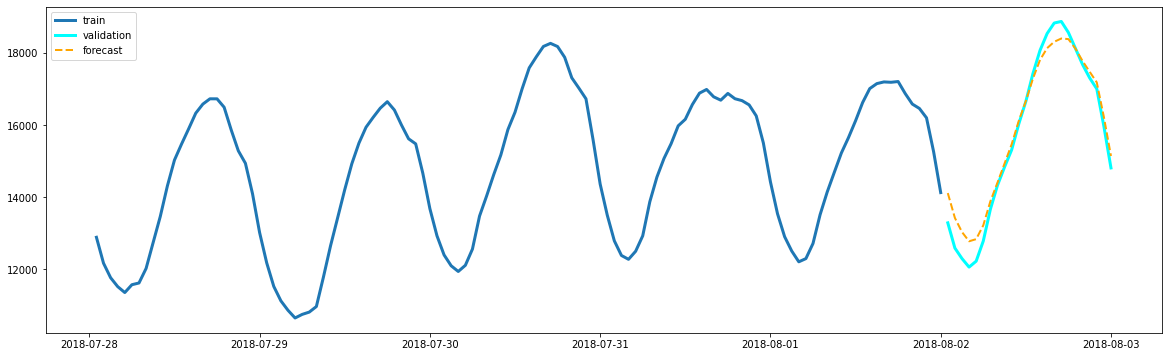

In [523]:
plot_forecast(preds)

In [524]:
print('RMSE - ', rmse(val.AEP_MW, preds))
print('MAPE - ', mean_absolute_percentage_error(val.AEP_MW,  preds))

RMSE -  414.17066746218853
MAPE -  2.2800701064253794


### Валидация для временного ряда

В реальных задачах у нас нет возможности "заглянуть в будущее", поэтому наша валидация должна полностью повторять ситуацию на тесте.

<img width = '700px' src="images/validation.png">

len_test -  24


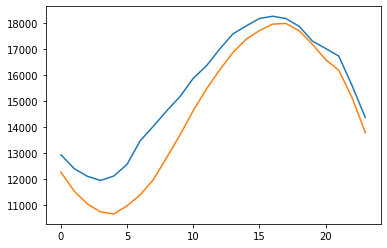

len_test -  24


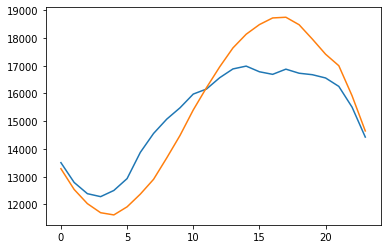

len_test -  24


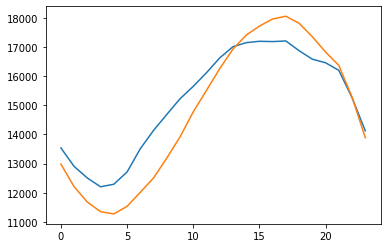

len_test -  24


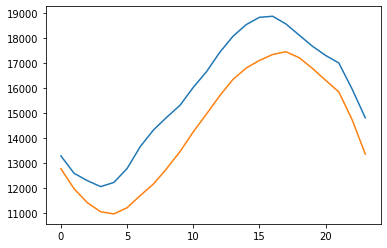

In [612]:
from sklearn.model_selection import TimeSeriesSplit 
errors = []

seasonal_period = 24
n_splits=4     

data_all = energy_consumption.AEP_MW
data_in_split = energy_consumption.AEP_MW[-seasonal_period * (n_splits + 1):]
data_not_in_split = energy_consumption.AEP_MW[:-seasonal_period * (n_splits + 1)]

tscv = TimeSeriesSplit(n_splits=n_splits, test_size = seasonal_period) 
for train_idx, test_idx in tscv.split(data_in_split):
    print('len_test - ', len(test_idx))
    train_data = data_not_in_split.append(data_in_split[train_idx])
    
    model = ExponentialSmoothing(train_data,
                                 seasonal_periods=24,
                                 trend='add', 
                                 seasonal='add' ).fit(smoothing_level = 0.4, 
                                                    smoothing_slope = 0.05)
    forecast = pd.Series(model.forecast(len(test_idx)))
    actual = data_in_split.iloc[test_idx]
    error = rmse(actual.values, forecast.values)
    errors.append(error)
    
    plt.plot(actual.values)
    plt.plot(forecast.values)
    plt.show()


In [613]:
errors

[1073.6930007434878, 1108.3963925022947, 867.8501818091144, 1467.2912954772114]

In [614]:
np.mean(errors)

1129.307717633027

### Модели класса ARIMA

Введем несколько понятий, которые будут необходимы для раюоты с временными рядами в рамках работы над моделями класса ARIMA.

#### **Стационарность**

Cвойство процесса не менять свои характеристики со временем называется стационарностью. Временной ряд стаицонарен, если его свойства не зависят от времени.

- постоянство матожидания

<img width = '500px' src="images/stat1.png">

- постоянство дисперсии (она же гомоскедастичность)

<img width = '500px' src="images/stat2.png">

- независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями)

<img width = '500px' src="images/stat3.png">

Временной ряд с сезонной компонентной и трендом - нестационарный, при этом временной ряд с циклом - стационарный, так как цикл не имеет фиксированной продолжительности.

**Вопрос**: зачем нужен именно стационарный временной ряд?

**Ответ**: по стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих.

#### Проверка временного ряда на стационарность

Способы определения стационарности временного ряда:
- визуально изучить плавающее среднее, плавающее стандартное отклонеение
- применить статистический тест

In [616]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 24, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

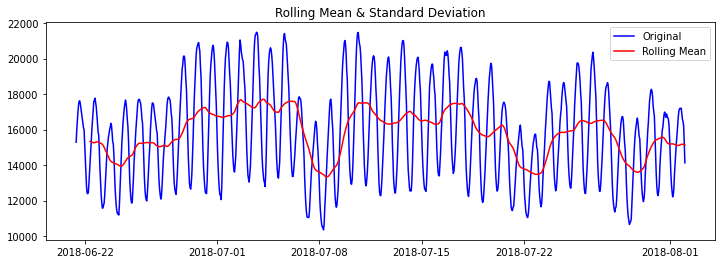

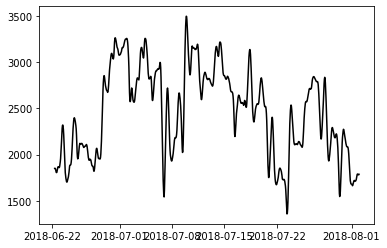

Results of Dickey-Fuller Test:
p-value = 0.1349. The series is likely non-stationary.
Test Statistic                  -2.424481
p-value                          0.134946
#Lags Used                      22.000000
Number of Observations Used    977.000000
Critical Value (1%)             -3.437061
Critical Value (5%)             -2.864503
Critical Value (10%)            -2.568348
dtype: float64


In [619]:
sample_data = train.AEP_MW[-1000:]
test_stationarity(sample_data)

Временной ряд **нестационарен**!

#### Преобразования нестационарного временного ряда в стационарный

Основные подходы:
- **логарифмирование**:  в случае непостоянства дисперсии ряда;
- **дифференцирование** (переход к попарным разностям ряда): стабилизирует среднее значение ряда, может применяться неоднократно.

Выделяют дифференцирование разных типов:
- дифференцирование первого порядка - просто попарные разницы между соседними наблюдениями

<img width = '200px' src="images/1_diff.png">

- дифферецнирование второго порядка

<img width = '400px' src="images/2_diff.png">

- сезонное дифференцирование

<img width = '200px' src="images/s_diff.png">

- применение сезонного дифференцирования, а затем уже дифференцирования второго порядка

<img width = '400px' src="images/s_2_diff.png">

Обычно хватает дифференцирования первого порядка, а если есть ярко выраженная сезональность, то сезонного дифференцирования.

#### Понятие автокорреляции

**Корреляция** (Пирсона) - сила линейной взаимосвязи между двумя случайными величинами.

Формула выборочной корреляции:
    
 $r_{X_1, X_2}  =\frac{ \sum_{i=1}^n (X_{1i} - \overline{X_1})(X_{2i} - \overline{X_2})}  {\sqrt{\sum_{i=1}^n (X_{1i} - \overline{X_1})^2\sum_{i=1}^n (X_{2i} - \overline{X_2})^2}} $   
 
 **Автокорреляция** (последовательная корреляция) - корреляция между последовательными показателями, упорядоченными во времени.

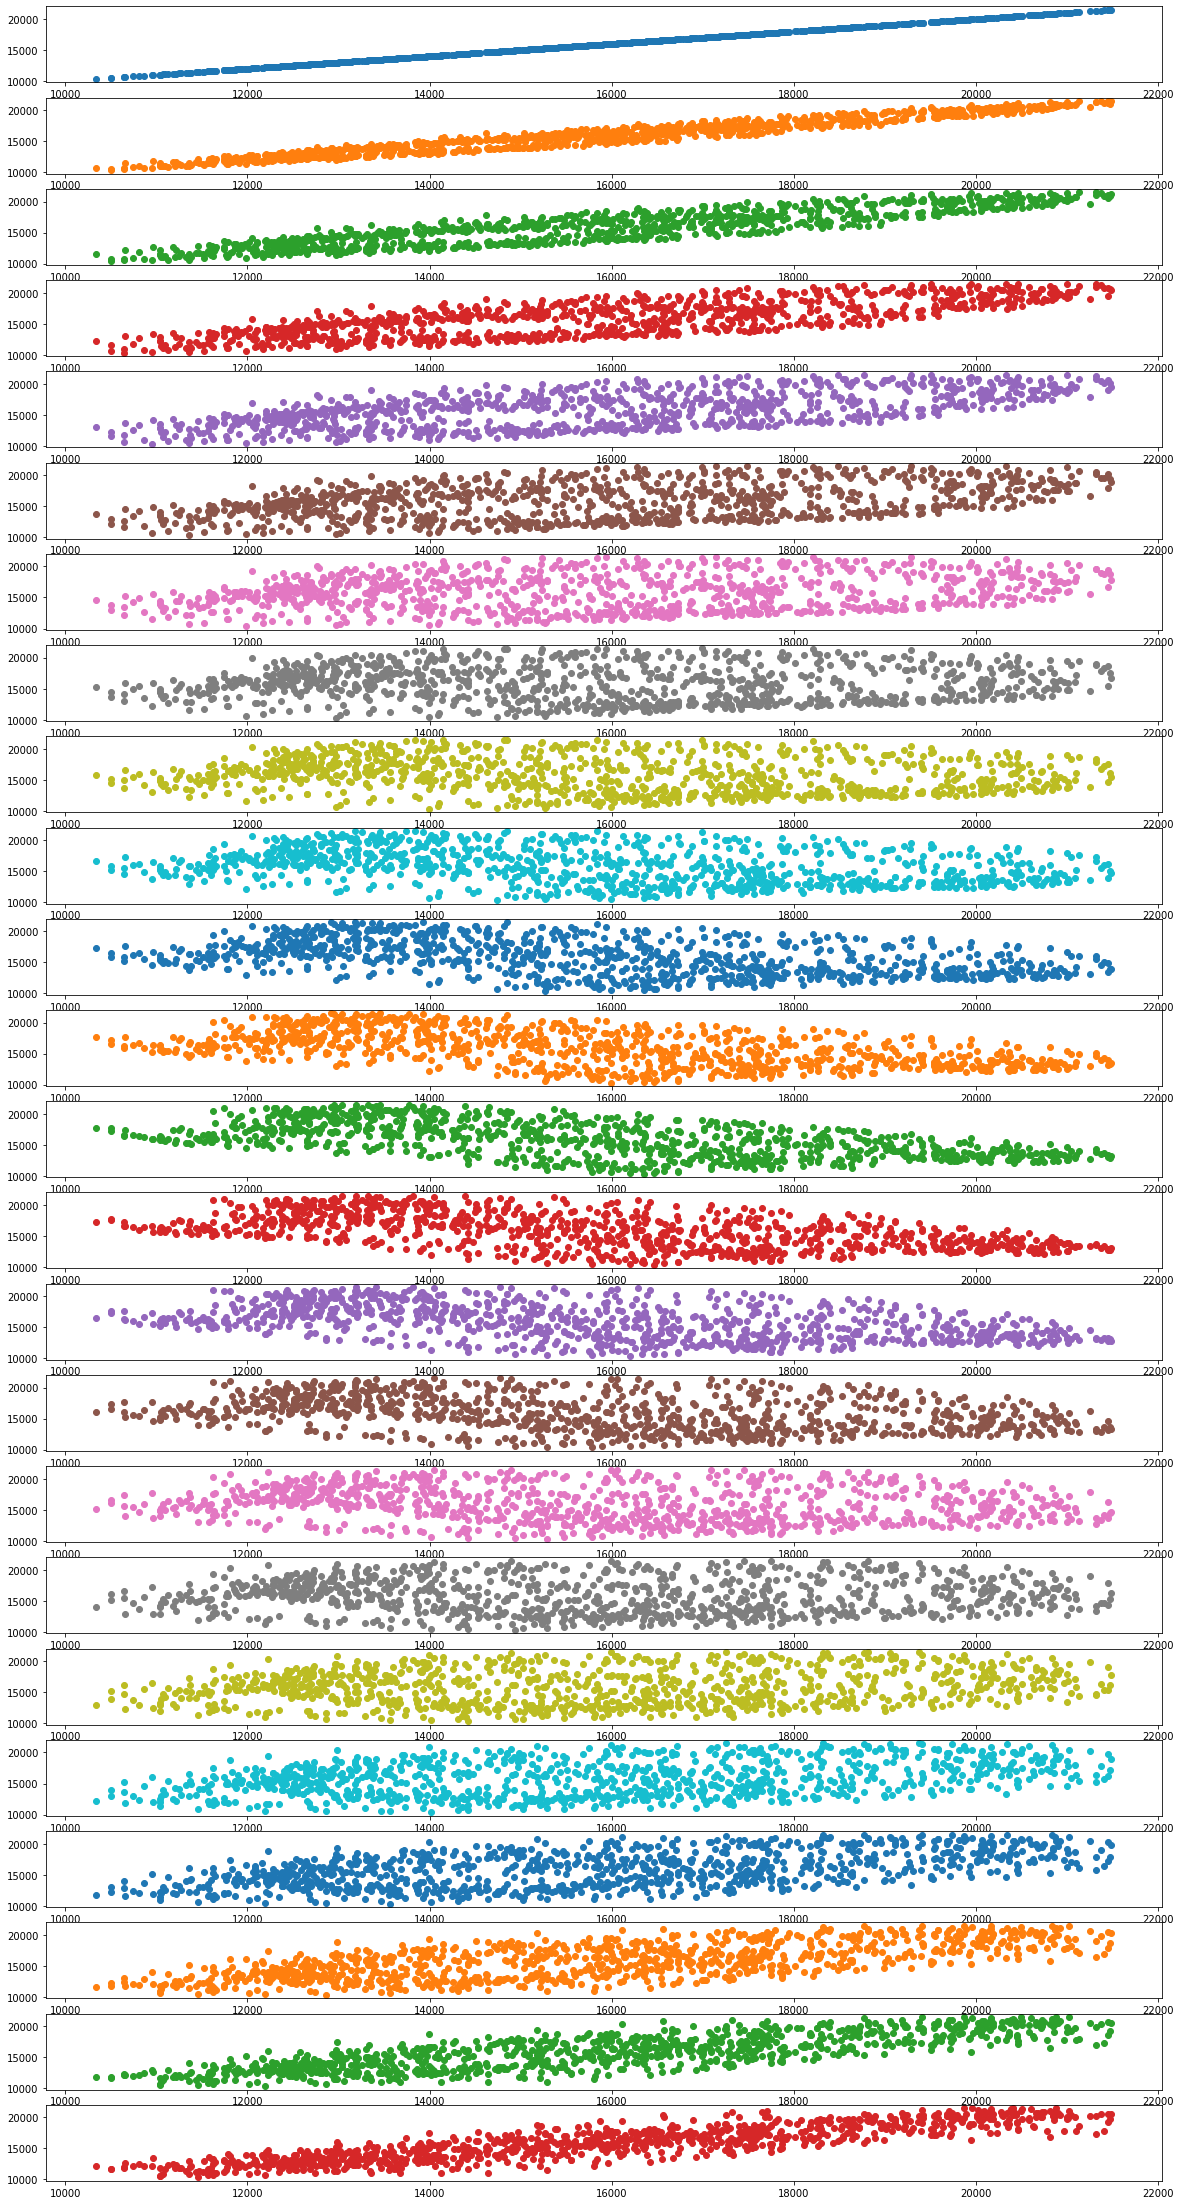

In [625]:
fig, axes = plt.subplots(24,1,figsize = (20,40))
for k, ax in enumerate(axes):
    for i in range(k):
        next(ax._get_lines.prop_cycler)
    ax.plot(sample_data,sample_data.shift(-k),'o')


plt.show()

Автокорреляция - корреляция между исходным рядом и его версией, который сдивнут на некий лаг **t** (лаг автокорреляции).

<img width = '500px' src="images/autocor.png">

### Компоненты модели ARIMA

**Модель ARIMA** = AR (Авторегрессия) + I(Интегрирование) + MA(Скользящее среднее). 

В рамках занятия будем рассматривать модель **S**ARIMA - она в том числе включает сезонную компоненту.

#### Модель AR

Надо понять влияние прошлых периодов на текущий период.

<img width = '500px' src="images/auto.png">

Модель - линейная комбинация **p** предыдущих значений ряда, шумовой компоненты и константы.

#### Модель MA

Будем строить модель, как линейную комбинацию **q** последних значений шумовой компоненты. 

Модель, где используется зависимость между наблюдением и остаточными ошибками от скользящей средней модели.

<img width = '500px' src="images/ma.png">

#### Классическая модель ARMA

<img width = '700px' src="images/arima.png">

#### Определение параметров модели SARIMA

Чтобы построить модель нам нужно знать ее порядок, состоящий из 6-х параметров:

- p,P — порядок компоненты AR
- d,D — порядок интегрированного ряда
- q,Q — порядок компонетны MA

С параметрами p и q уже знакомы из описанных моделей выше, а аналоги Q и P будут относиться к сезонным лагам.

*Для p,P и q,Q надо изучить авторкорреляционную(ACF) и частную автокорреляционную(PACF) функции для ряда первых разностей.
ACF поможет нам определить q и Q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA.
PACF поможет нам определить p и P, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.*

Рассмотрим пример подбора компонентов модели на примере.

##### 1. Подбор d и D - дифференцирование для стационарности временного ряда

Исходный временной ряд нестационарен. Попробуем сделать простое дифференцирование и оценить стационарность получившегося ряда с помощью статистического теста.

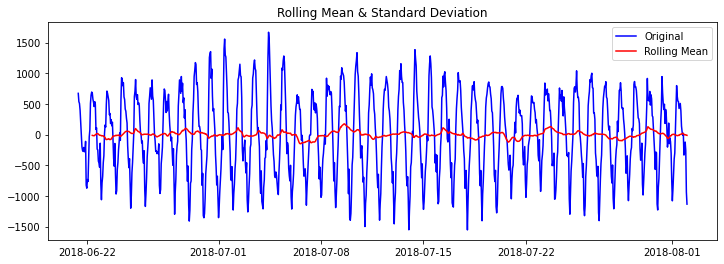

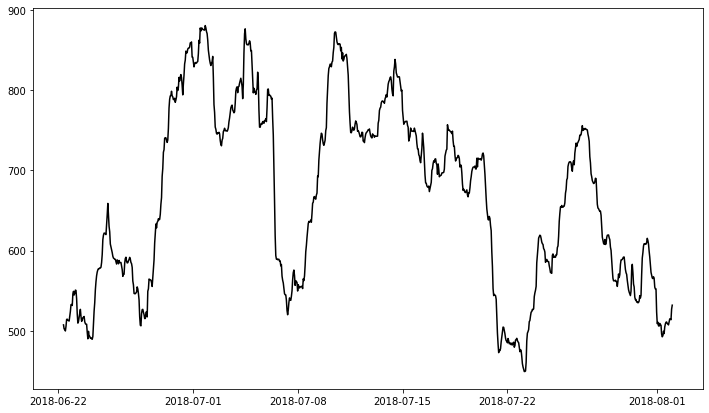

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -5.842911e+00
p-value                        3.741023e-07
#Lags Used                     2.200000e+01
Number of Observations Used    9.760000e+02
Critical Value (1%)           -3.437068e+00
Critical Value (5%)           -2.864506e+00
Critical Value (10%)          -2.568349e+00
dtype: float64


In [634]:
rcParams['figure.figsize'] = 12, 7
sample_data_diff = sample_data - sample_data.shift(1)
sample_data_diff.dropna(inplace = True)
test_stationarity(sample_data_diff)

Получившийся ряд - стационарен. В случае несезонного дифференцирования первого порядка получаем первую комопненту **d** = 1, **D** = 0 (сезонное дифференцирование не проводилось). 

##### 2. Определение компонент p и P

**Частичная автокорреляционная функция** показывает корреляцию между двумя случайными переменными за вычетом влияния всех внутренних значений автокорреляции. 

<img width = '400px' src="images/partial_autocor.png">

Автокорреляция показывает зависимость между $y_4$ и $y_1$, при этом игнорируя эффект от изменения $y_2$ и $y_3$. А частичная автокорреляция также показывает эффект между $y_4$ и $y_1$, при этом учитывая, что эффект от $y_2$ и $y_3$ отсутсвует, то есть убирает эффекты $y_2$ и $y_3$.

Рекомендации к подбору первоначальных приближений:

P(p) - номер последнего сезонного (несезонного) лага, при котором частичная автокорреляция значима (персекается граница доверительного интервала), при этом стоит учитывать, что большое число компонентов ведет к увеличению сложности модели и переобучению, если Р > 0, то p не может быть больше сезонного лага.

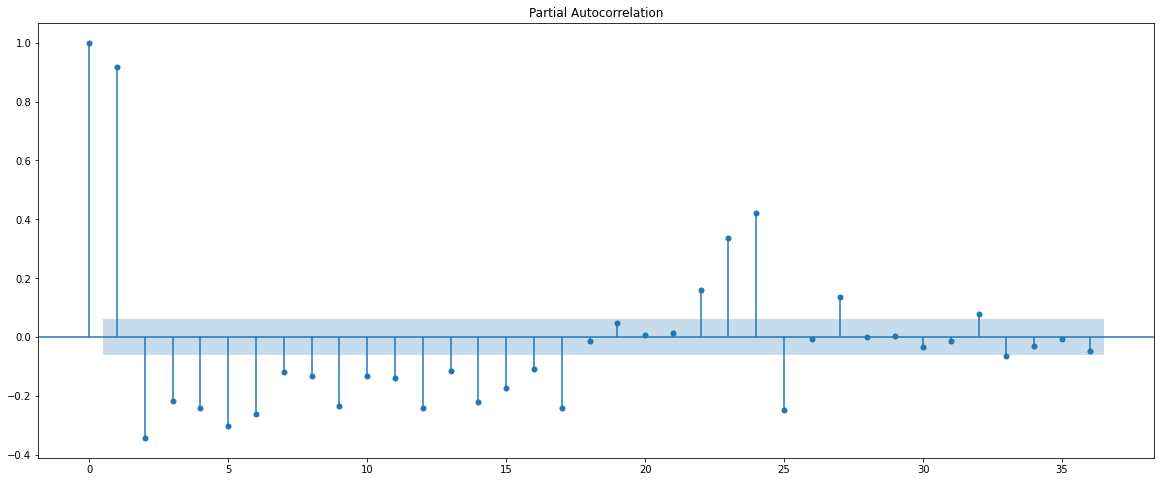

In [637]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_pacf(sample_data_diff.values, lags=36,ax = ax)
plt.show()

In [638]:
p = 1
P = 1

##### 3. Определение компонент q и Q


**Автокорреляционная функция** показывает значения автокорреляции временного ряда с его запаздывающими значениями. 

Q(q) - номер последнего сезонного (несезонного) лага, при котором автокорреляция значима, если Q > 0, то q не может быть больше сезонного лага.

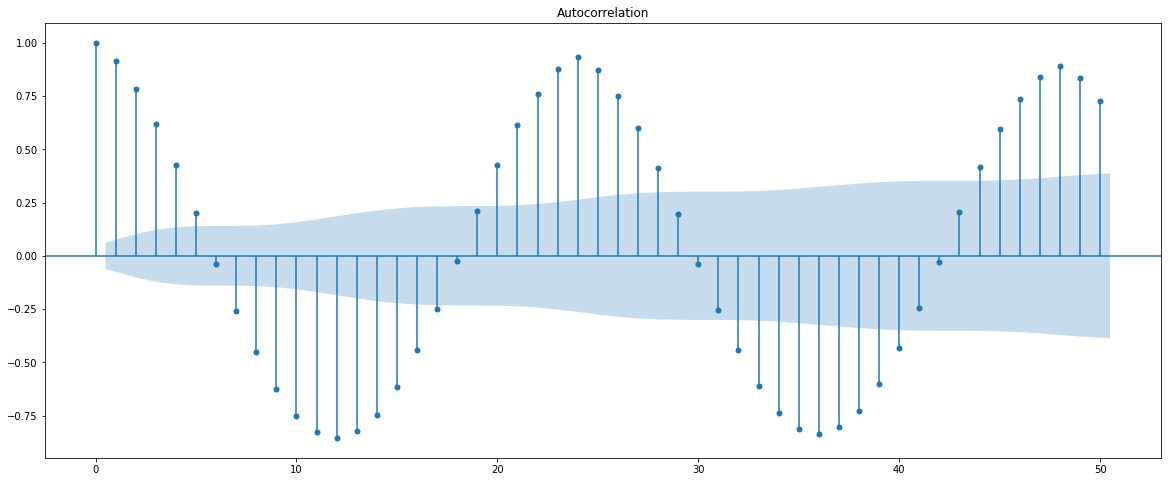

In [639]:
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_acf(sample_data_diff.values, lags=50, ax = ax)
plt.show()

In [640]:
q = 1
Q = 1

##### 4. Построение прогноза

In [641]:
d = 1
D = 0
s = 24

q = 1
Q = 1
p = 1
P = 1

In [648]:
model=sm.tsa.statespace.SARIMAX(sample_data, order=(p, d, q), 
                                        seasonal_order=(P,D,Q, s)).fit(disp=-1)

In [650]:
print(model.summary().tables[0])
print(model.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                             AEP_MW   No. Observations:                 1000
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood               -6451.625
Date:                            Sat, 19 Feb 2022   AIC                          12913.250
Time:                                    15:01:11   BIC                          12937.784
Sample:                                06-21-2018   HQIC                         12922.575
                                     - 08-02-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6849      0.022     30.531      0.000       0.641       0.729
ma.L1          0.0534      0.026   

Изучим остатки модели, действительно ли они представляют белый шум.

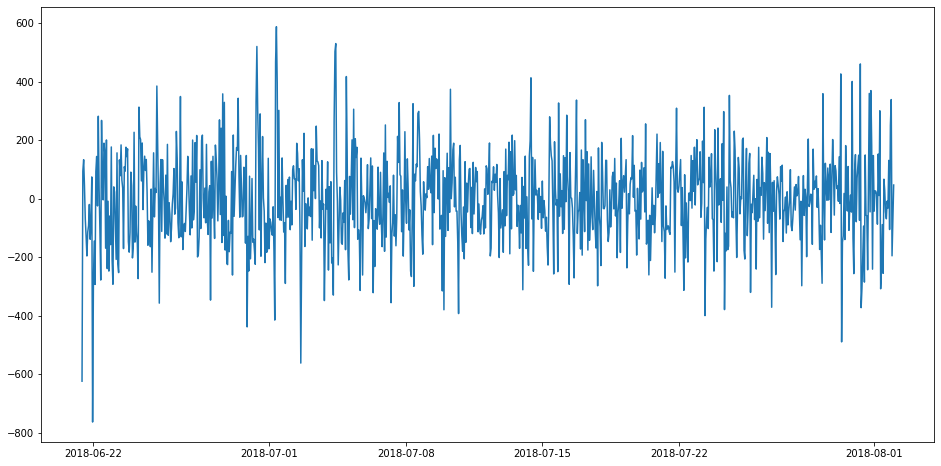

In [654]:
# Остатки модели
plt.figure(figsize=(16,8))
plt.plot(model.resid[1:])
plt.show()

In [656]:
stat_test = sm.tsa.adfuller(model.resid[:])
print ('adf: ', stat_test[0] )
print ('p-value: ', stat_test[1])
print('Critical values: ', stat_test[4])
if stat_test[0]> stat_test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -13.151445865681241
p-value:  1.3643467064216138e-24
Critical values:  {'1%': -3.4370198458812156, '5%': -2.864484708707697, '10%': -2.568337912084273}
единичных корней нет, ряд стационарен


Построим прогноз.

In [651]:
forecast = model.predict(start = sample_data.shape[0], end = sample_data.shape[0]+23)

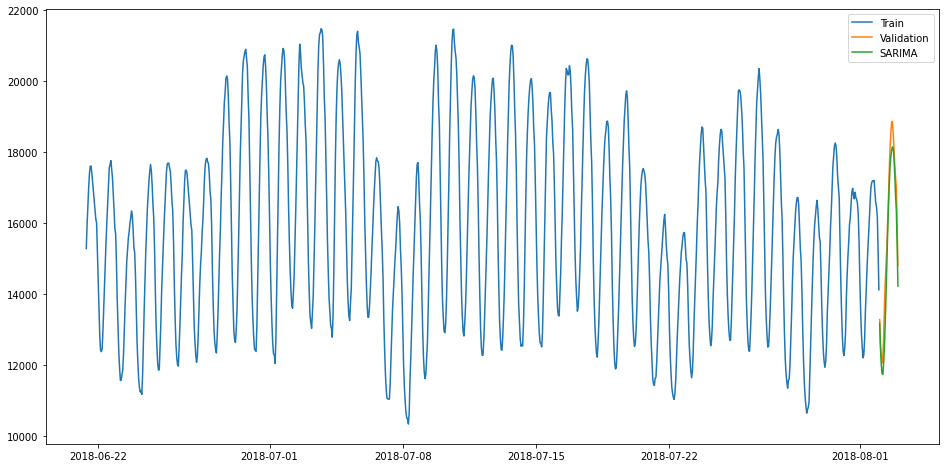

In [652]:
plt.figure(figsize=(16,8))
plt.plot(sample_data, label='Train')
plt.plot(val.AEP_MW, label='Validation')
plt.plot(forecast, label='SARIMA')
plt.legend(loc='best')
plt.show()

In [653]:
print('RMSE - ', rmse(val.AEP_MW, forecast))
print('MAPE - ', mean_absolute_percentage_error(val.AEP_MW,  forecast))

RMSE -  592.4025977676911
MAPE -  3.3908124433486306


### Prophet

In [669]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

In [670]:
train.head()

,AEP_MW,label
Datetime,,
2015-03-02 00:00:00,15867.0,train
2015-03-02 01:00:00,15444.0,train
2015-03-02 02:00:00,15307.0,train
2015-03-02 03:00:00,15328.0,train
2015-03-02 04:00:00,15373.0,train


In [671]:
train_dataset= pd.DataFrame()
train_dataset['ds'] = pd.to_datetime(train.index)
train_dataset['y']  = train.AEP_MW.values
train_dataset.head(2)

,ds,y
0,2015-03-02 00:00:00,15867.0
1,2015-03-02 01:00:00,15444.0


In [672]:
prophet_basic = Prophet()
prophet_basic.fit(train_dataset)

Initial log joint probability = -190.086


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       65075.3    0.00668886       1481.35           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       65176.7   0.000988602       291.241      0.4798      0.4798      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       65196.2    0.00898292       1685.08           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       65204.2    0.00354578       140.287           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       65211.5    0.00100894       390.492      0.4776           1      561   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [673]:
future= prophet_basic.make_future_dataframe(periods= 24, freq = 'H')
future.tail(2)

  65223.4   0.000867244       165.617      0.5487      0.5487      672   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       65228.1   0.000551186        333.14           1           1      778   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     758       65230.2   2.42294e-05       236.235   6.435e-08       0.001      897  LS failed, Hessian reset 
     799       65231.5     0.0002544       233.021      0.9133      0.9133      942   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       65233.9    0.00592307       186.316           1           1     1061   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       65237.3    0.00288949       126.382      0.5346      0.5346     1182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    101

,ds
29995,2018-08-02 23:00:00
29996,2018-08-03 00:00:00


In [674]:
forecast=prophet_basic.predict(future)

In [675]:
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-03-02 00:00:00,15555.127204,12231.131388,16456.474859,15555.127204,15555.127204,-1250.054892,-1250.054892,-1250.054892,-821.161147,...,-440.541292,-440.541292,-440.541292,11.647548,11.647548,11.647548,0.0,0.0,0.0,14305.072313
1,2015-03-02 01:00:00,15554.522370,11769.612893,15634.348337,15554.522370,15554.522370,-1875.388500,-1875.388500,-1875.388500,-1513.681335,...,-372.014375,-372.014375,-372.014375,10.307210,10.307210,10.307210,0.0,0.0,0.0,13679.133870


In [676]:
preds = forecast['yhat'].iloc[-24:]
preds.index = val.index

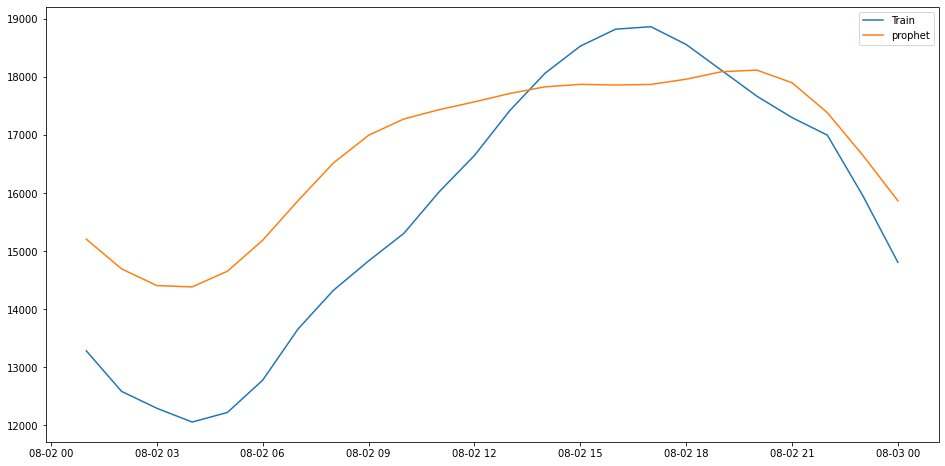

In [677]:
plt.figure(figsize=(16,8))
plt.plot(val.AEP_MW, label='Train')
plt.plot(preds, label='prophet')
plt.legend(loc='best')
plt.show()

In [678]:
print('RMSE - ', rmse(val.AEP_MW, forecast['yhat'].iloc[-24:].values))
print('MAPE - ', mean_absolute_percentage_error(val.AEP_MW,  forecast['yhat'].iloc[-24:].values))

RMSE -  1528.2135506300094
MAPE -  9.162136002379574
